In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv


In [2]:
import optuna
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

In [3]:
df = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv")
df_valid = pd.read_csv("/kaggle/input/playground-series-s4e10/test.csv")
test = pd.read_csv("/kaggle/input/playground-series-s4e10/sample_submission.csv")

In [4]:
test

,id,loan_status
0,58645,0.5
1,58646,0.5
2,58647,0.5
3,58648,0.5
4,58649,0.5
...,...,...
39093,97738,0.5
39094,97739,0.5
39095,97740,0.5
39096,97741,0.5


In [5]:
df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [7]:
df.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [8]:
df.isnull().sum()

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [9]:
# df['loan_int_amount'] = df['loan_amnt'] * df['loan_int_rate']
# df_valid['loan_int_amount'] = df_valid['loan_amnt'] * df['loan_int_rate']

# df['loan_to_income_ratio'] = df['loan_amnt'] / df['person_income']
# df_valid['loan_to_income_ratio'] = df_valid['loan_amnt'] / df_valid['person_income']


# df['interest_to_income_ratio'] = df['loan_int_rate'] / df['person_income']
# df_valid['interest_to_income_ratio'] = df_valid['loan_int_rate'] / df_valid['person_income']


# df['debt_to_income_ratio'] = df['loan_percent_income'] * df['loan_amnt']
# df_valid['debt_to_income_ratio'] = df_valid['loan_percent_income'] * df_valid['loan_amnt']

# df = df.drop(columns=['loan_percent_income', 'loan_amnt', 'person_income', 'loan_int_rate'])
# df_valid = df_valid.drop(columns=['loan_percent_income', 'loan_amnt', 'person_income', 'loan_int_rate'])


In [10]:
df.shape

(58645, 13)

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# plt.figure(figsize = (12,6))
# plt.subplot(1,2,1)
# sns.histplot(df['person_age'], kde = True)
# plt.xlabel("Person age")
# plt.ylabel('Frequency')
# plt.title("Distribution of person age")

# plt.subplot(1,2,2)
# sns.histplot(df['person_income'], kde = True)
# plt.xlabel("Person income")
# plt.ylabel("Frequency")
# plt.title("Distribution of person income")

In [13]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# plt.figure(figsize = (12,6))
# plt.subplot(1,2,1)
# sns.histplot(df['loan_amnt'], kde = True)
# plt.xlabel("Loan Amount")
# plt.ylabel('Frequency')
# plt.title("Distribution of Loan Amount")

# plt.subplot(1,2,2)
# sns.histplot(df['loan_int_rate'], kde = True)
# plt.xlabel("Loan Interest Rate")
# plt.ylabel("Frequency")
# plt.title("Distribution of Loan Interest Rate")

In [14]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# plt.figure(figsize = (12,6))
# plt.subplot(1,2,1)
# sns.histplot(df['loan_percent_income'], kde = True)
# plt.xlabel("Loan Percent Income")
# plt.ylabel('Frequency')
# plt.title("Distribution of Loan Percent Income")

# plt.subplot(1,2,2)
# sns.histplot(df['loan_int_rate'], kde = True)
# plt.xlabel("Loan Interest Rate")
# plt.ylabel("Frequency")
# plt.title("Distribution of Loan Interest Rate")

In [15]:
# sns.histplot(df['loan_status'])
# plt.xlabel("Loan Status")
# plt.ylabel("Frequency")
# plt.title("Distribution of Loan Status")

<Axes: >

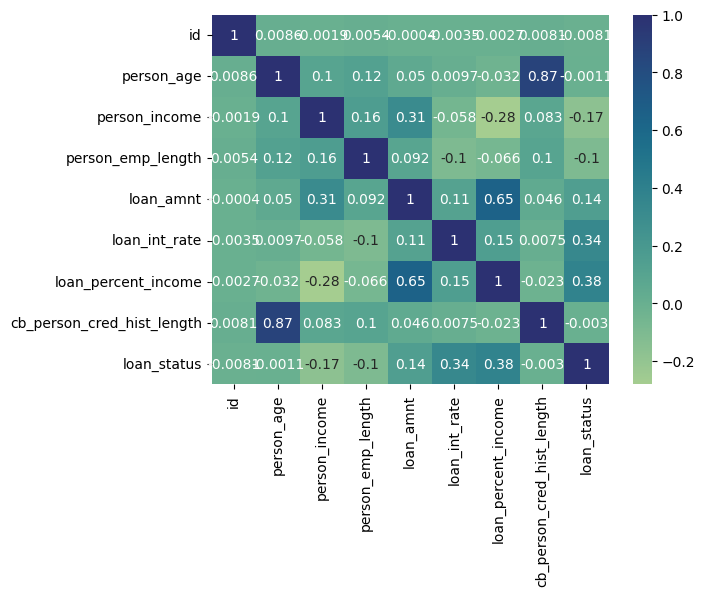

In [16]:
corr = df.select_dtypes(include=['float64','int64']).corr()
sns.heatmap(corr, annot = True, cmap = 'crest')

In [17]:
from sklearn.feature_selection import mutual_info_classif

Xm = df.select_dtypes(include=['float64','int64']).drop(columns = 'loan_status')
ym = df['loan_status']

mi_scores = mutual_info_classif(Xm, ym)

mi_scores_df = pd.DataFrame({'Feature': Xm.columns, 'Mutual Information': mi_scores})
mi_scores_df

,Feature,Mutual Information
0,id,0.000000
1,person_age,0.000025
2,person_income,0.096132
3,person_emp_length,0.006947
4,loan_amnt,0.016683
5,loan_int_rate,0.082466
6,loan_percent_income,0.081244
7,cb_person_cred_hist_length,0.000682


In [18]:
#Not needed columns: person age, person emp length, cb person, try with and without them


In [19]:
X = df.drop(columns = 'loan_status')
y = df['loan_status']

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.0002, random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((58633, 12), (12, 12), (58633,), (12,))

In [21]:
categorical_cols = [cname for cname in X_train.columns if 
                   X_train[cname].nunique() < 10 and
                   X_train[cname].dtype == 'object']

categorical_cols_high = [cname for cname in X_train.columns if 
                   X_train[cname].nunique() > 10 and
                   X_train[cname].dtype == 'object']

numerical_cols = [cname for cname in X_train.columns if
                 X_train[cname].dtype in ['int64', 'float64']]

print("Categorical columns with low cardinality are: ", categorical_cols)
print("Categorical columns with high cardinality are: ", categorical_cols_high)
print("Numerical columns are: ", numerical_cols)

Categorical columns with low cardinality are:  ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
Categorical columns with high cardinality are:  []
Numerical columns are:  ['id', 'person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']


In [22]:
# for column in df[numerical_cols]:
#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
#     IQR = Q3 - Q1
    
#     # Define bounds for outliers
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
    
#     # Remove rows where the feature is outside the bounds (either too high or too low)
#     df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]


In [23]:
X_train = pd.get_dummies(X_train, drop_first = True)
X_test = pd.get_dummies(X_test, drop_first = True)
df_valid = pd.get_dummies(df_valid, drop_first = True)

In [24]:
ids = df_valid['id']

In [25]:
# smote = SMOTE(random_state=42)
# smote_enn = SMOTEENN(random_state=42)

# X_train, y_train = smote_enn.fit_resample(X_train, y_train)

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
df_valid  = scaler.transform(df_valid)

In [27]:
df_valid = pd.DataFrame(df_valid)

In [28]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

# models = {
#     'Logistic Regression': LogisticRegression(),
#     'Decision Tree': DecisionTreeClassifier(),
#     'Random Forest': RandomForestClassifier(),
#     'SVM': SVC(),
#     'XGBoost': XGBClassifier()
# }

# model_results = []

# for model_name, model in models.items():
#     model.fit(X_train, y_train)
    
#     y_pred = model.predict(X_test)
    
#     accuracy = accuracy_score(y_test, y_pred)
    
#     model_results.append({
#         'Model': model_name,
#         'Accuracy': accuracy
#     })

# model_results

In [29]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.3],
#     'n_estimators': [100, 200, 300],
# }

# grid_search = GridSearchCV(estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss'), 
#                            param_grid=param_grid, 
#                            scoring='accuracy', 
#                            cv=5, 
#                            verbose=1)

# grid_search.fit(X_train, y_train)

# print("Best parameters:", grid_search.best_params_)


In [30]:
# from xgboost import XGBClassifier
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import roc_curve, roc_auc_score

# xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', learning_rate = 0.1, max_depth = 7, n_estimators = 100)
# xgb.fit(X_train, y_train)
# y_pred = xgb.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# accuracy

In [31]:
# y_prob = xgb.predict_proba(X_test)[:, 1]  # Probability of the positive class (1)

# # Step 3: Plot ROC curve
# fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# plt.plot(fpr, tpr, label="ROC curve")
# plt.plot([0, 1], [0, 1], 'k--', label="Random guess")  # Diagonal line
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate (Recall)")
# plt.title("ROC Curve")
# plt.legend(loc="best")
# plt.show()

# # Step 4: Calculate AUC
# auc_score = roc_auc_score(y_test, y_prob)
# auc_score

In [32]:
# model_results

In [33]:
# output = pd.DataFrame({'id': df_valid.id,'loan_status': df_valid['loan_status']})
# output.to_csv('submission.csv', index=False)

In [34]:
# output

In [35]:
!pip install catboost --quiet

In [36]:
import optuna
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import cross_val_score

In [37]:
# def objective(trial):
#     # Suggest hyperparameters for CatBoostClassifier
#     param = {
#         'iterations': trial.suggest_int('iterations', 100, 1000),  # Number of boosting iterations
#         'depth': trial.suggest_int('depth', 4, 10),  # Depth of the trees
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),  # Learning rate
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 10),  # L2 regularization
#         'border_count': trial.suggest_int('border_count', 32, 255),  # Number of splits for numeric features
#         'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),  # Bagging temperature
#         'random_strength': trial.suggest_float('random_strength', 0.0, 10.0),  # Random strength
#         'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.5, 2.0),  # For imbalanced classes
#         'task_type': 'CPU',  # If you have a GPU, use 'GPU'
#         'eval_metric': 'Accuracy',  # Evaluation metric (for classification)
#         'verbose': 0,  # Verbose mode off
#     }
    
#     # Initialize the CatBoostClassifier with the suggested hyperparameters
#     model = CatBoostClassifier(**param)

#     # Train the model
#     model.fit(X_train, y_train)
    
#     # Predict on the test set
#     y_pred = model.predict(X_test)
    
#     # Evaluate the accuracy
#     auc_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    
#     return auc_scores.mean()  # Return the evaluation metric for Optuna to maximize

# # Create a study object and maximize accuracy
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

# # Print the best hyperparameters found by Optuna
# print("Best hyperparameters:", study.best_params)

In [38]:
# params = {'iterations': 479,
#           'depth': 4,
#           'learning_rate': 0.1848769699739462, 
#           'l2_leaf_reg': 3.0269030589006416,
#           'border_count': 255,
#           'bagging_temperature': 0.09480704285119582,
#           'random_strength': 9.011716736975744, 
#           'scale_pos_weight': 1.8844087181714746}

# model = CatBoostClassifier(**params)

# model.fit(X_train, y_train, verbose = 0)
# y_pred = model.predict(X_test)

# print("Cv svore is: ", cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc'))
# print("Auc score is: ", roc_auc_score(y_pred, y_test))



In [39]:
# #Final
params = {'lambda': 0.0065466961116540275,
          'alpha': 1.1645845783973294,
          'learning_rate': 0.29948497255354056,
          'n_estimators': 549,
          'max_depth': 5,
          'min_child_weight': 5, 
          'subsample': 0.9968858194825716, 
          'colsample_bytree': 0.8679717638642047}

from xgboost import XGBClassifier
xgb = XGBClassifier(**params)
xgb.fit(X_train, y_train)

print("Cv svore is: ",cross_val_score(xgb, X_train, y_train, cv=5, scoring='roc_auc'))
y_pred = xgb.predict(df_valid)
# print("Auc score is: ",roc_auc_score(y_pred2, y_test))

Cv svore is:  [0.94883623 0.94690216 0.94431066 0.9507507  0.9457718 ]


In [40]:
# import xgboost as xgb
# def objective(trial):
#     # Suggest hyperparameters for XGBoost
#     param = {
#         'objective': 'binary:logistic',  # Binary classification
#         'eval_metric': 'auc',  # Using AUC as the evaluation metric
#         'booster': 'gbtree',
#         'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),  # L2 regularization
#         'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),  # L1 regularization
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),  # Step size shrinkage
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),  # Number of trees
#         'max_depth': trial.suggest_int('max_depth', 3, 10),  # Maximum depth of each tree
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # Minimum sum of instance weight
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # Subsample ratio of the training data
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # Subsample ratio of columns
#     }
    
#     # Create XGBoost DMatrix (for better memory efficiency)
#     dtrain = xgb.DMatrix(X_train, label=y_train)
#     dtest = xgb.DMatrix(X_test, label=y_test)

#     # Train the XGBoost model with the suggested hyperparameters
#     model = xgb.train(param, dtrain, evals=[(dtest, 'eval')], early_stopping_rounds=100, verbose_eval=False)
    
#     # Predict probabilities
#     preds = model.predict(dtest)
    
#     # Calculate AUC
#     auc = roc_auc_score(y_test, preds)
    
#     return auc

# # Create a study object and maximize the AUC score
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

# # Print the best hyperparameters found by Optuna
# print("Best hyperparameters:", study.best_params)

# # Print the best AUC score
# print(f"Best AUC score: {study.best_value:.4f}")


In [41]:
df_valid['loan_status'] = y_pred
df_valid['id'] = ids
df_valid.head()
output = pd.DataFrame({'id': df_valid.id,'loan_status': df_valid['loan_status']})
output.to_csv('submission.csv', index=False)